# Root inference with a neural network model

__Obejctive:__ experiment with generating data and fitting a NN model to predict the root.

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

sys.path.append('../modules/')

from logger import get_logger
from tree_generation import calcrho, generate_dataset, compute_rho_entropy
from models import FFNN
from training import training_step, EarlyStopper
from model_evaluation import compute_accuracy, load_experiment_catalog, save_experiment_info
from plotting import plot_training_history

sns.set_theme()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Available device:', device)

logger = get_logger('nn_test')

%load_ext autoreload
%autoreload 2

Available device: cuda


## Generate dataset

In [2]:
DATA_DIR = '../data/'
EXPERIMENT_CATALOG_PATH = '../data/experiment_catalog.csv'

In [11]:
n_samples = 8000
k = 5
q = 3
matrix_type = 'uniform_index_sets'
sigma = None
eps = 0.015

rho = calcrho(matrix_type, q=q, eps=eps)
rho, trees, roots, leaves = generate_dataset(rho, n_samples, k, q)

rho_entropy = compute_rho_entropy(rho, q)

roots, leaves, leaves.shape, rho_entropy

(array([2, 1, 0, ..., 0, 0, 2]),
 array([[1, 1, 1, ..., 0, 1, 1],
        [0, 2, 1, ..., 1, 0, 2],
        [1, 2, 2, ..., 0, 2, 2],
        ...,
        [0, 2, 1, ..., 2, 2, 0],
        [2, 2, 2, ..., 1, 1, 1],
        [1, 2, 1, ..., 0, 1, 1]]),
 (8000, 32),
 0.34657359027997264)

In [14]:
# # # Save generated data.
# dataset_name = 'exp_2'

# dataset_dir = os.path.join(DATA_DIR, dataset_name)

# if not os.path.exists(dataset_dir):
#     os.makedirs(dataset_dir)

#     logger.info(f'Created data directory: {dataset_dir}')

# with open(os.path.join(dataset_dir, 'rho.npy'), 'wb') as f:
#     np.save(f, rho)

# with open(os.path.join(dataset_dir, 'roots.npy'), 'wb') as f:
#     np.save(f, roots)

# with open(os.path.join(dataset_dir, 'trees.npy'), 'wb') as f:
#     np.save(f, trees)

# with open(os.path.join(dataset_dir, 'leaves.npy'), 'wb') as f:
#     np.save(f, leaves)

In [15]:
# # # To load a saved dataset.
# dataset_name = 'exp_1'

# dataset_dir = os.path.join(DATA_DIR, dataset_name)

# with open(os.path.join(dataset_dir, 'rho.npy'), 'rb') as f:
#     rho = np.load(f)

# with open(os.path.join(dataset_dir, 'roots.npy'), 'rb') as f:
#     roots = np.load(f)

# with open(os.path.join(dataset_dir, 'trees.npy'), 'rb') as f:
#     trees = np.load(f)

# with open(os.path.join(dataset_dir, 'leaves.npy'), 'rb') as f:
#     leaves = np.load(f)

# q = np.unique(roots).shape[0]

# print(f'N roots: {q} | N leaves: {leaves.shape[1]} | N samples: {leaves.shape[0]}')

## Model

In [16]:
# def mask_input(leaves, prob, masked_symbols_bound=1):
#     """
#     """
#     for i in range(leaves.shape[0]):
#         masked_symbols = 0
        
#         for j in range(leaves.shape[1]):
#             if np.random.uniform() < prob:
#                 leaves[i, j] 

In [12]:
# # Train-test split.
# test_frac = .2

# test_indices = np.random.choice(range(leaves.shape[0]), int(leaves.shape[0] * test_frac), replace=False)
# train_indices = np.array(list(set(range(leaves.shape[0])) - set(test_indices)))

# x_train = torch.nn.functional.one_hot(torch.from_numpy(leaves[train_indices, :]), num_classes=q).to(dtype=torch.float32).to(device=device)
# y_train = torch.nn.functional.one_hot(torch.from_numpy(roots[train_indices]), num_classes=q).to(dtype=torch.float32).to(device=device)
# x_test = torch.nn.functional.one_hot(torch.from_numpy(leaves[test_indices, :]), num_classes=q).to(dtype=torch.float32).to(device=device)
# y_test = torch.nn.functional.one_hot(torch.from_numpy(roots[test_indices]), num_classes=q).to(dtype=torch.float32).to(device=device)

x_train = torch.nn.functional.one_hot(torch.from_numpy(leaves), num_classes=q).to(dtype=torch.float32).to(device=device)
y_train = torch.nn.functional.one_hot(torch.from_numpy(roots), num_classes=q).to(dtype=torch.float32).to(device=device)

n_test_samples = 2000

_, _, test_roots, test_leaves = generate_dataset(rho, n_test_samples, k, q)

x_test = torch.nn.functional.one_hot(torch.from_numpy(test_leaves), num_classes=q).to(dtype=torch.float32).to(device=device)
y_test = torch.nn.functional.one_hot(torch.from_numpy(test_roots), num_classes=q).to(dtype=torch.float32).to(device=device)

x_train.shape, x_test.shape

(torch.Size([8000, 32, 3]), torch.Size([2000, 32, 3]))

In [13]:
dims = [leaves.shape[-1], 64, q]

model = FFNN(
    dims=dims,
    activation='relu',
    output_activation='softmax',
    batch_normalization=False,
    concatenate_last_dim=True
).to(device=device)

print(f'N params: {sum(p.numel() for p in model.parameters())}')

loss_fn = torch.nn.CrossEntropyLoss()

epoch_counter = 0

training_history = {
    'training_loss': [],
    'val_loss': [],
    'training_accuracy': [],
    'val_accuracy': []
}

# Test.
loss_fn(
    model(x_train),
    y_train
)

N params: 6403


tensor(1.0988, device='cuda:0', grad_fn=<DivBackward1>)

2024-03-14 17:32:58,003 - nn_test - DEBUG - Epoch: 1 | Training loss: 1.0839452743530273 | Validation loss: 1.0730036497116089
2024-03-14 17:32:58,316 - nn_test - DEBUG - Epoch: 2 | Training loss: 1.0616679191589355 | Validation loss: 1.0689681768417358
2024-03-14 17:32:58,628 - nn_test - DEBUG - Epoch: 3 | Training loss: 1.0565818548202515 | Validation loss: 1.070248007774353
2024-03-14 17:32:58,939 - nn_test - DEBUG - Epoch: 4 | Training loss: 1.052614450454712 | Validation loss: 1.07120680809021
2024-03-14 17:32:59,247 - nn_test - DEBUG - Epoch: 5 | Training loss: 1.048599362373352 | Validation loss: 1.0710657835006714
2024-03-14 17:32:59,555 - nn_test - DEBUG - Epoch: 6 | Training loss: 1.0432791709899902 | Validation loss: 1.0749001502990723
2024-03-14 17:32:59,864 - nn_test - DEBUG - Epoch: 7 | Training loss: 1.0378159284591675 | Validation loss: 1.0700362920761108
2024-03-14 17:33:00,172 - nn_test - DEBUG - Epoch: 8 | Training loss: 1.0318868160247803 | Validation loss: 1.073780

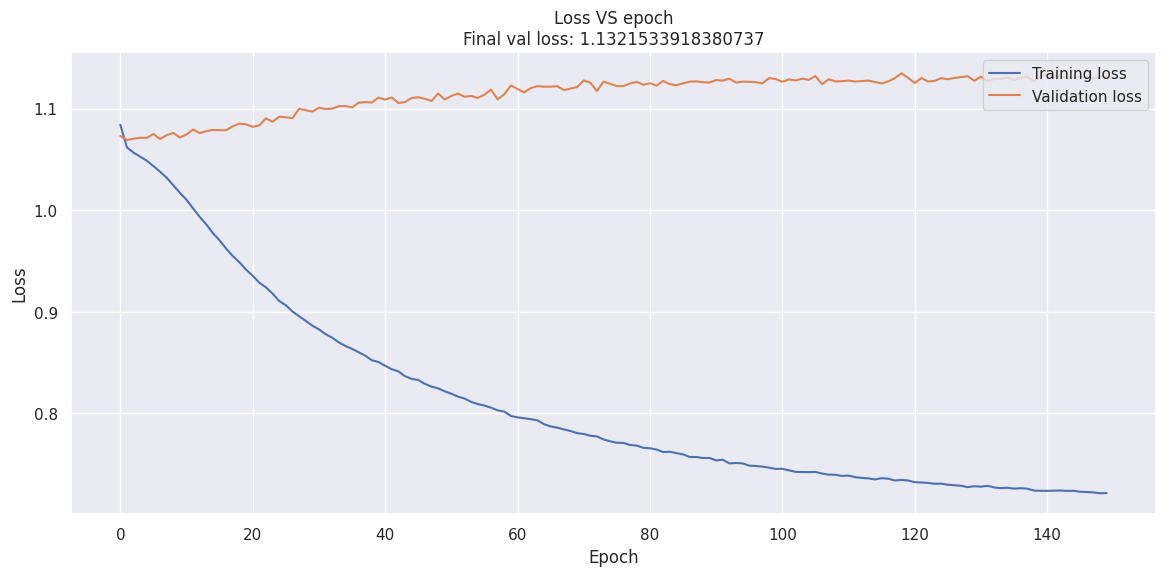

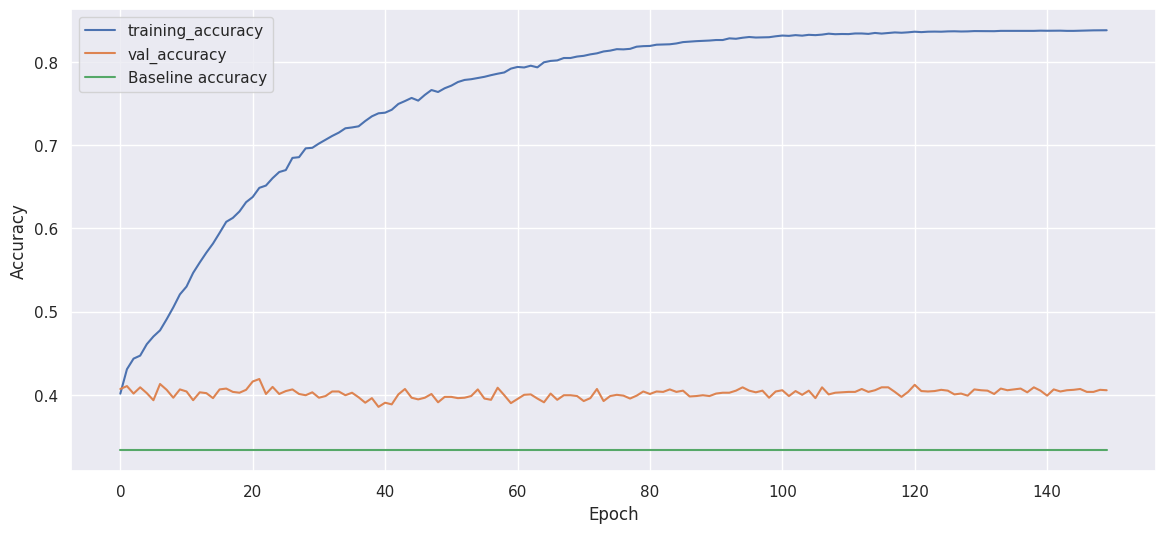

In [14]:
learning_rate = 1e-3
batch_size = 32

optimizer = torch.optim.Adam(
    params=model.parameters(),
    lr=learning_rate
)

# early_stopper = EarlyStopper(
#     patience=5,
#     min_delta=0.
# )
early_stopper = None

training_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(x_train, y_train),
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)

n_epochs = 150

# Training loop.
for i in range(n_epochs):
    epoch_counter += 1

    training_loss_batches = []
    training_accuracy_batches = []

    for batch in training_loader:
        training_batch, training_targets = batch
    
        training_loss_batch, _ = training_step(
            (training_batch, training_targets),
            model,
            loss_fn,
            optimizer,
        )

        training_loss_batches.append(training_loss_batch)

        # Compute the training accuracy over the batch and append it to
        # the corresponding list.
        training_accuracy_batch = compute_accuracy(model(training_batch), training_targets)
        training_accuracy_batches.append(training_accuracy_batch)

    # Training loss and accuracy for one epoch is computed as the average
    # training loss over the batches.
    training_loss = torch.tensor(training_loss_batches).mean()
    training_accuracy = torch.tensor(training_accuracy_batches).mean()

    training_history['training_loss'].append(training_loss)
    training_history['training_accuracy'].append(training_accuracy)

    if x_test is not None:
        with torch.no_grad():
            val_loss = loss_fn(model(x_test), y_test)
            val_accuracy = compute_accuracy(model(x_test), y_test)
    else:
        val_loss = None
        val_accuracy = None

    training_history['val_loss'].append(
        val_loss if val_loss is not None else None
    )

    training_history['val_accuracy'].append(
        val_accuracy if val_accuracy is not None else None
    )

    if (i < 50) or (i % 50 == 0):
        logger.debug(
            f'Epoch: {epoch_counter}'
            f' | Training loss: {training_history["training_loss"][-1]}'
            f' | Validation loss: {training_history["val_loss"][-1]}'
        )

    if (x_test is not None) and (early_stopper is not None):
        if early_stopper.early_stop(training_history['val_loss'][-1]):
            logger.debug(
                f'Early stopping epoch: {epoch_counter}'
                f' | Training loss: {training_history["training_loss"][-1]}'
                f' | Validation loss: {training_history["val_loss"][-1]}'
            )
            
            break
    elif (early_stopper is not None):
        if early_stopper.early_stop(training_history['training_loss'][-1]):
            logger.debug(
                f'Early stopping epoch: {epoch_counter}'
                f' | Training loss: {training_history["training_loss"][-1]}'
            )
            
            break

training_history['training_loss'] = torch.tensor(training_history['training_loss']).tolist()
training_history['training_accuracy'] = torch.tensor(training_history['training_accuracy']).tolist()
training_history['val_loss'] = torch.tensor(training_history['val_loss']).tolist()
training_history['val_accuracy'] = torch.tensor(training_history['val_accuracy']).tolist()

logger.info(f'Last epoch: {epoch_counter}')

baseline_accuracy = 1. / q

plot_training_history(training_history, baseline_accuracy=baseline_accuracy)

logger.info(f'Final test accuracy: {training_history["val_accuracy"][-1]} (baseline: {baseline_accuracy})')

In [15]:
save_experiment_info(
    '../data/experiment_catalog.csv',
    **{
        'experiment_id': 'exp_s37',
        'matrix_type': matrix_type,
        'eps': eps,
        'sigma': sigma,
        'matrix_entropy': rho_entropy,
        'k': k,
        'q': q,
        'n_samples': n_samples,
        'dims': dims,
        'learning_rate': learning_rate,
        'batch_size': batch_size,
        'n_epochs': n_epochs,
        'final_train_loss': training_history['training_loss'][-1],
        'final_val_loss': training_history['val_loss'][-1],
        'final_train_accuracy': training_history['training_accuracy'][-1],
        'final_val_accuracy': training_history['val_accuracy'][-1],
        'baseline_accuracy': baseline_accuracy
    }
)

experiment_catalog = load_experiment_catalog(EXPERIMENT_CATALOG_PATH)

experiment_catalog

exp_s37


/home/moscato/projects/tree-language/notebooks/../modules/model_evaluation.py:403: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  experiment_catalog = pd.concat(


,experiment_id,matrix_type,eps,matrix_entropy,k,q,n_samples,dims,learning_rate,batch_size,n_epochs,final_train_loss,final_val_loss,final_train_accuracy,final_val_accuracy,baseline_accuracy,sigma
0,exp_s1,simplified,0.100,0.682652,5,3,8000,"[32, 64, 3]",0.001,32,150,0.740669,1.198269,0.824125,0.335000,0.333333,NaN
1,exp_s2,simplified,0.050,0.474708,5,3,8000,"[96, 64, 3]",0.001,32,150,0.769854,1.131823,0.792625,0.404000,0.333333,NaN
2,exp_s3,simplified,0.010,0.140421,5,3,8000,"[96, 64, 3]",0.001,32,150,0.619061,0.652415,0.932250,0.897000,0.333333,NaN
3,exp_s4,simplified,0.005,0.079220,5,3,8000,"[96, 64, 3]",0.001,32,150,0.580387,0.596764,0.971125,0.953500,0.333333,NaN
4,exp_s5,simplified,0.040,0.407672,5,3,8000,"[96, 64, 3]",0.001,32,150,0.781584,1.053328,0.772500,0.491000,0.333333,NaN
5,exp_s6,simplified,0.030,0.331284,5,3,8000,"[96, 64, 3]",0.001,32,150,0.757035,0.920495,0.794500,0.625500,0.333333,NaN
6,exp_s7,simplified,0.020,0.243659,5,3,8000,"[96, 64, 3]",0.001,32,150,0.690608,0.801397,0.860125,0.747500,0.333333,NaN
7,exp_s8,simplified,0.015,0.194471,5,3,8000,"[96, 64, 3]",0.001,32,150,0.652447,0.697916,0.898500,0.852000,0.333333,NaN
8,exp_s9,lognormal,NaN,0.205469,5,3,8000,"[96, 64, 3]",0.001,32,150,0.704504,0.802574,0.850125,0.744500,0.333333,5.0
9,exp_s10,lognormal,NaN,0.159475,5,3,8000,"[96, 64, 3]",0.001,32,150,0.652227,0.825283,0.904500,0.718500,0.333333,5.0


Text(0.5, 1.0, 'Accuracy VS entropy\n(simplified transition matrices)')

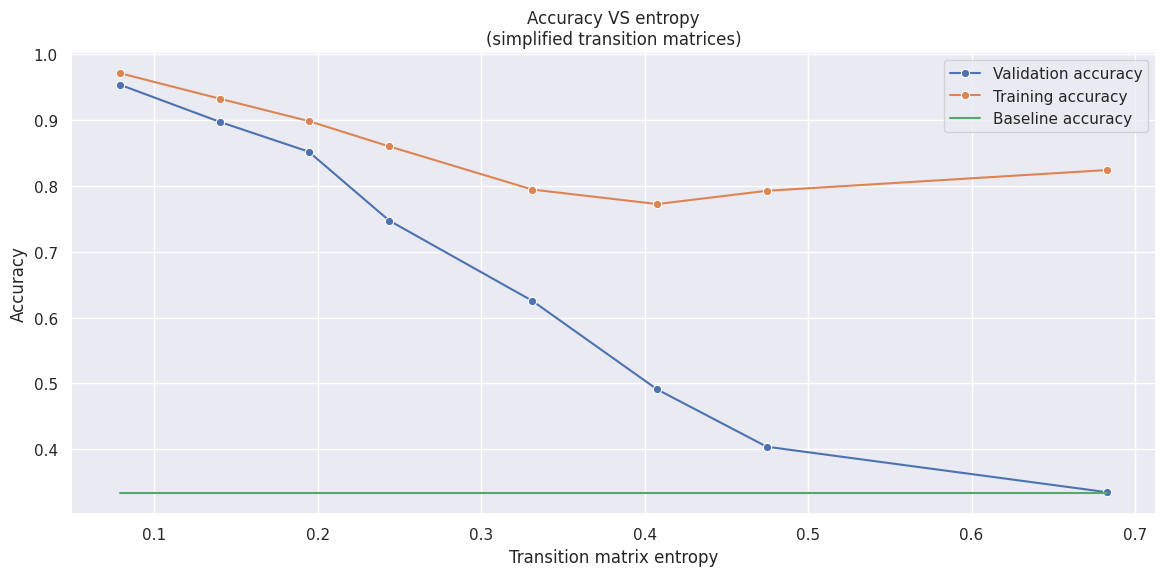

In [167]:
fig = plt.figure(figsize=(14, 6))

matrix_type = 'simplified'

sns.lineplot(
    x=experiment_catalog[experiment_catalog['matrix_type'] == matrix_type].sort_values(by='matrix_entropy', ascending=True)['matrix_entropy'],
    y=experiment_catalog[experiment_catalog['matrix_type'] == matrix_type].sort_values(by='matrix_entropy', ascending=True)['final_val_accuracy'],
    label='Validation accuracy',
    marker='o'
)

sns.lineplot(
    x=experiment_catalog[experiment_catalog['matrix_type'] == matrix_type].sort_values(by='matrix_entropy', ascending=True)['matrix_entropy'],
    y=experiment_catalog[experiment_catalog['matrix_type'] == matrix_type].sort_values(by='matrix_entropy', ascending=True)['final_train_accuracy'],
    label='Training accuracy',
    marker='o'
)

sns.lineplot(
    x=experiment_catalog[experiment_catalog['matrix_type'] == matrix_type].sort_values(by='matrix_entropy', ascending=True)['matrix_entropy'],
    y=experiment_catalog[experiment_catalog['matrix_type'] == matrix_type].sort_values(by='matrix_entropy', ascending=True)['baseline_accuracy'],
    label='Baseline accuracy'
)

plt.legend()
plt.xlabel('Transition matrix entropy')
plt.ylabel('Accuracy')
plt.title('Accuracy VS entropy\n(simplified transition matrices)')

Text(0.5, 1.0, 'Accuracy VS entropy\n(lognormal with $\\sigma = 5$)')

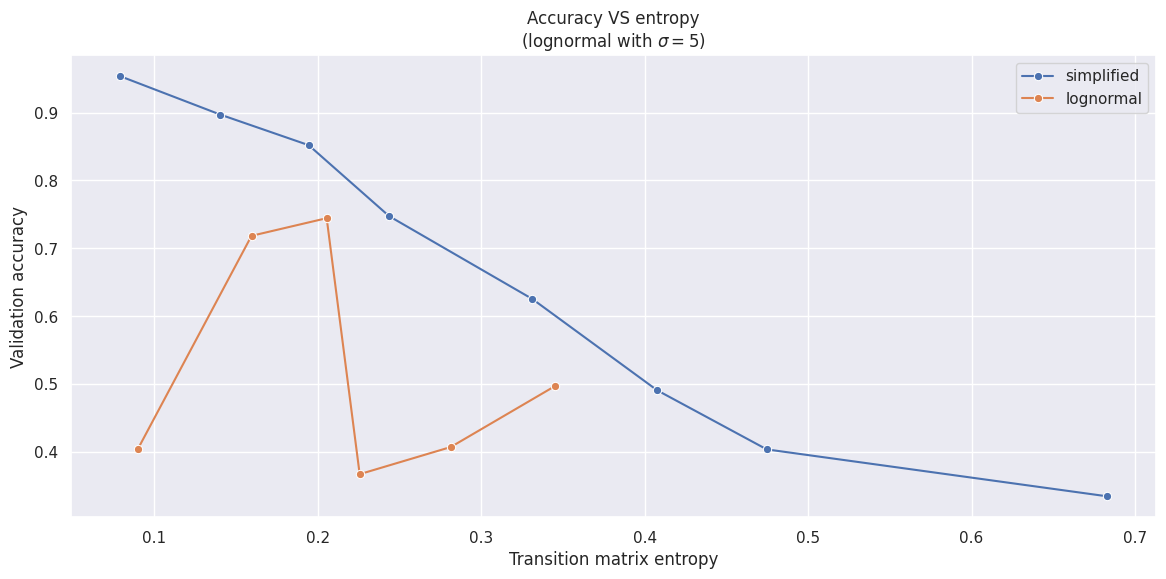

In [170]:
fig = plt.figure(figsize=(14, 6))

for matrix_type in experiment_catalog['matrix_type'].unique():
    sns.lineplot(
        x=experiment_catalog[experiment_catalog['matrix_type'] == matrix_type].sort_values(by='matrix_entropy', ascending=True)['matrix_entropy'],
        y=experiment_catalog[experiment_catalog['matrix_type'] == matrix_type].sort_values(by='matrix_entropy', ascending=True)['final_val_accuracy'],
        label=matrix_type,
        marker='o'
    )
    
plt.legend()
plt.xlabel('Transition matrix entropy')
plt.ylabel('Validation accuracy')
plt.title('Accuracy VS entropy\n(lognormal with $\sigma = 5$)')

Text(0.5, 1.0, 'Final validation accuracy VS sample size\n(simplified matrices, $\\epsilon$=0.015)')

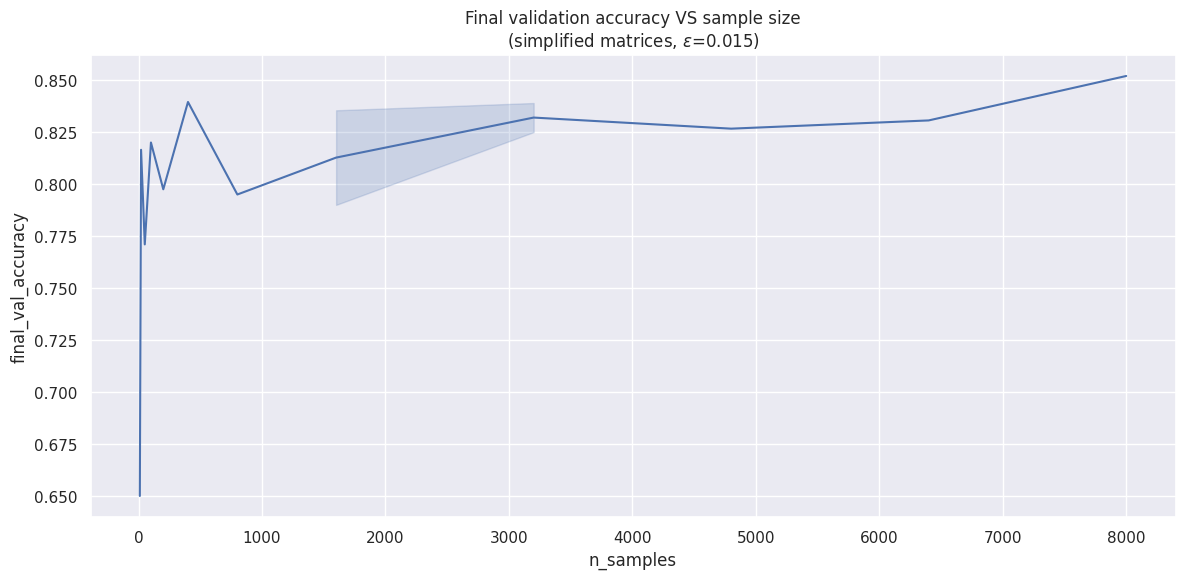

In [194]:
fig = plt.figure(figsize=(14, 6))

sns.lineplot(
    data=experiment_catalog[
        (experiment_catalog['matrix_type'] == 'simplified')
        & (experiment_catalog['eps'] == 0.015)
    ][['n_samples', 'final_val_accuracy']],#.drop_duplicates(),
    x='n_samples',
    y='final_val_accuracy'
)

plt.title('Final validation accuracy VS sample size\n(simplified matrices, $\epsilon$=0.015)')

In [48]:
experiment_catalog['dims']

0     [32, 64, 3]
1     [96, 64, 3]
2     [96, 64, 3]
3     [96, 64, 3]
4     [96, 64, 3]
5     [96, 64, 3]
6     [96, 64, 3]
7     [96, 64, 3]
8     [96, 64, 3]
9     [96, 64, 3]
10    [96, 64, 3]
11    [96, 64, 3]
12    [96, 64, 3]
13    [96, 64, 3]
14    [96, 64, 3]
15    [96, 64, 3]
16    [96, 64, 3]
17    [96, 64, 3]
18    [96, 64, 3]
19    [96, 64, 3]
20    [96, 64, 3]
21    [96, 64, 3]
22    [96, 64, 3]
23    [96, 64, 3]
24    [96, 64, 3]
25    [96, 64, 3]
26    [96, 64, 3]
27    [96, 32, 3]
28    [96, 32, 3]
29    [96, 16, 3]
30     [96, 8, 3]
31     [96, 4, 3]
32     [96, 2, 3]
33     [96, 1, 3]
34     [96, 1, 3]
35        [96, 3]
Name: dims, dtype: object

In [67]:
experiment_catalog[
        (experiment_catalog['matrix_type'] == 'simplified')
        & (experiment_catalog['eps'] == 0.015)
        & (experiment_catalog['n_samples'] == 8000)
    ]

,experiment_id,matrix_type,eps,matrix_entropy,k,q,n_samples,dims,learning_rate,batch_size,n_epochs,final_train_loss,final_val_loss,final_train_accuracy,final_val_accuracy,baseline_accuracy,sigma,intermediate_layer_width
7,exp_s8,simplified,0.015,0.194471,5,3,8000,"[96, 64, 3]",0.001,32,150,0.652447,0.697916,0.898500,0.8520,0.333333,NaN,64
28,exp_s29,simplified,0.015,0.194471,5,3,8000,"[96, 32, 3]",0.001,32,150,0.663964,0.701751,0.888000,0.8490,0.333333,NaN,32
29,exp_s30,simplified,0.015,0.194471,5,3,8000,"[96, 16, 3]",0.001,32,150,0.671401,0.699861,0.881125,0.8490,0.333333,NaN,16
30,exp_s31,simplified,0.015,0.194471,5,3,8000,"[96, 8, 3]",0.001,32,150,0.678060,0.697709,0.875625,0.8530,0.333333,NaN,8
31,exp_s32,simplified,0.015,0.194471,5,3,8000,"[96, 4, 3]",0.001,32,150,0.683437,0.695268,0.870750,0.8545,0.333333,NaN,4
32,exp_s33,simplified,0.015,0.194471,5,3,8000,"[96, 2, 3]",0.001,32,150,0.686215,0.699146,0.866750,0.8520,0.333333,NaN,2
33,exp_s34,simplified,0.015,0.194471,5,3,8000,"[96, 1, 3]",0.001,32,150,0.747244,0.750670,0.804500,0.7985,0.333333,NaN,1
34,exp_s35,simplified,0.015,0.194471,5,3,8000,"[96, 1, 3]",0.001,32,150,0.747244,0.750670,0.804500,0.7985,0.333333,NaN,1
35,exp_s36,simplified,0.015,0.194471,5,3,8000,"[96, 3]",0.001,32,150,0.688168,0.694969,0.865000,0.8545,0.333333,NaN,0


<Axes: xlabel='intermediate_layer_width', ylabel='final_val_accuracy'>

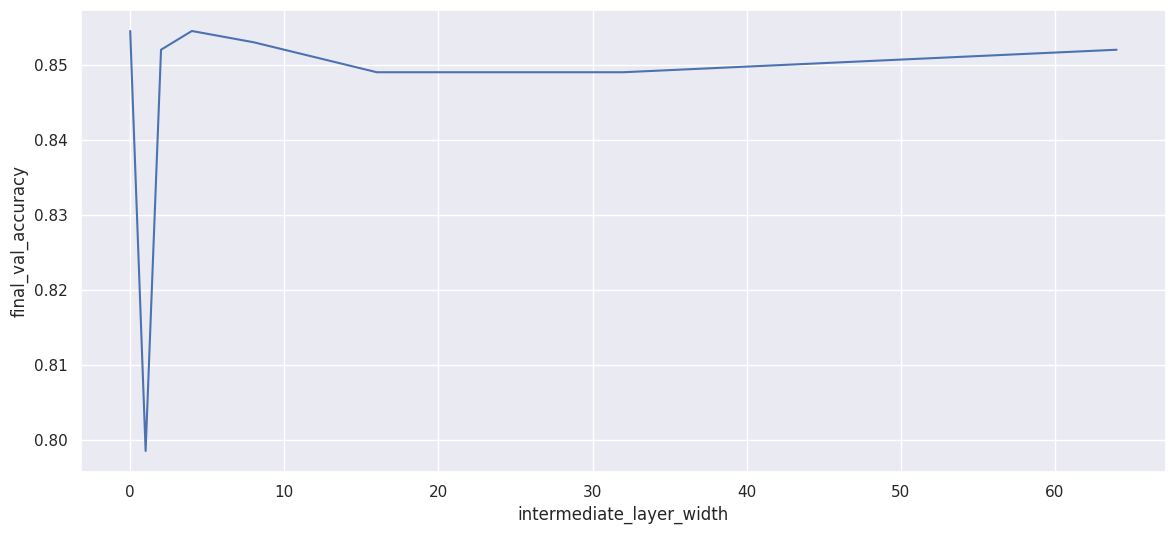

In [68]:
experiment_catalog['intermediate_layer_width'] = experiment_catalog['dims'].apply(lambda l: l[1] if len(l) == 3 else 0)

fig = plt.figure(figsize=(14, 6))

sns.lineplot(
    data=experiment_catalog[
        (experiment_catalog['matrix_type'] == 'simplified')
        & (experiment_catalog['eps'] == 0.015)
        & (experiment_catalog['n_samples'] == 8000)
    ],
    x='intermediate_layer_width',
    y='final_val_accuracy'
)

## Distribution of entropy of log-normally distributed transition matrices for different $\sigma$

In [172]:
from tree_generation import calcrho_lognormal

In [173]:
entropies_sigma = {}

for sigma_test in range(1, 11):
    logger.info(f'Sigma tested: {sigma_test}')
    
    entropies_sigma[sigma_test] = [compute_rho_entropy(calcrho_lognormal(q, sigma_test), q) for _ in range(1000)]

2024-03-12 17:56:23,304 - nn_test - INFO - Sigma tested: 1
2024-03-12 17:56:23,364 - nn_test - INFO - Sigma tested: 2
2024-03-12 17:56:23,427 - nn_test - INFO - Sigma tested: 3
2024-03-12 17:56:23,486 - nn_test - INFO - Sigma tested: 4
2024-03-12 17:56:23,546 - nn_test - INFO - Sigma tested: 5
2024-03-12 17:56:23,606 - nn_test - INFO - Sigma tested: 6
2024-03-12 17:56:23,665 - nn_test - INFO - Sigma tested: 7
2024-03-12 17:56:23,724 - nn_test - INFO - Sigma tested: 8
2024-03-12 17:56:23,784 - nn_test - INFO - Sigma tested: 9
2024-03-12 17:56:23,843 - nn_test - INFO - Sigma tested: 10


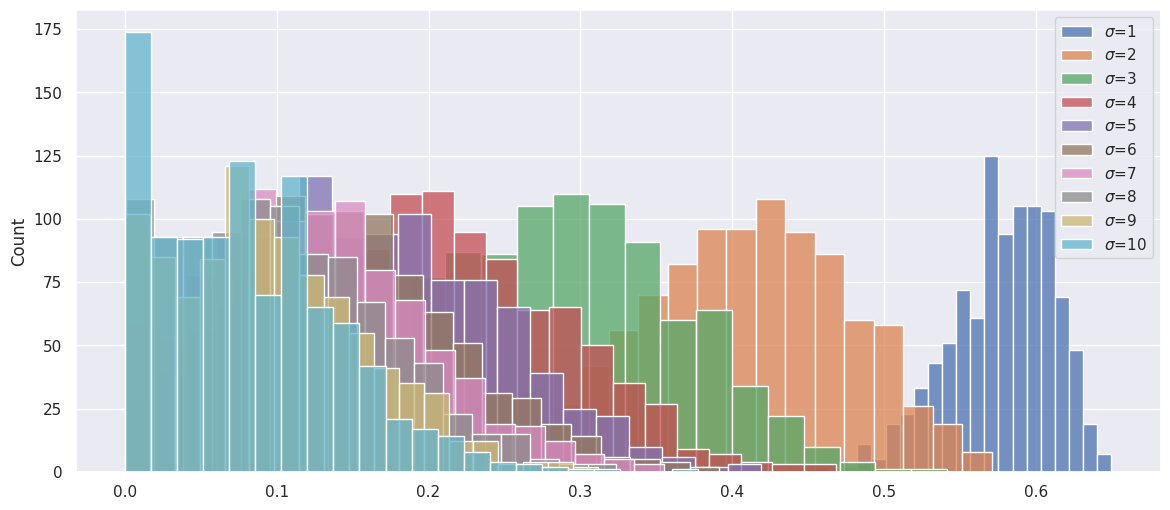

In [177]:
fig = plt.figure(figsize=(14, 6))

for sigma_test in sorted(entropies_sigma.keys()):
    sns.histplot(
        entropies_sigma[sigma_test],
        label=f'$\sigma$={sigma_test}'
    )

plt.legend()